# **Importing Libraries**

In [89]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

# **Load Dataset**

In [90]:
df = pd.read_csv("shampoo_sales.csv", index_col="Month")
month = np.array(list(df.index))
df

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3
1-06,168.5
1-07,231.8
1-08,224.5
1-09,192.8


# **Data Visualisation**

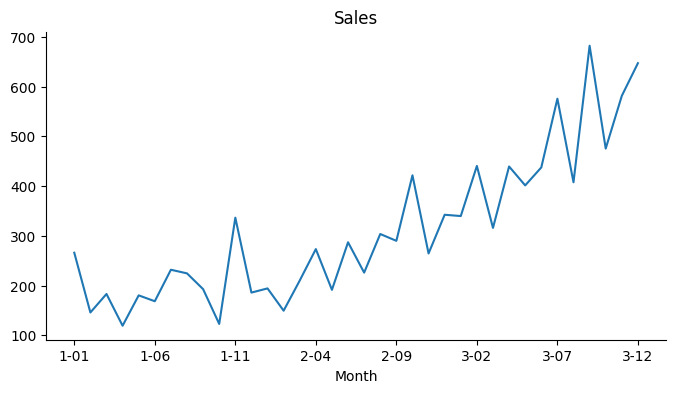

In [91]:
df['Sales'].plot(kind='line', figsize=(8, 4), title='Sales')
plt.gca().spines[['top', 'right']].set_visible(False)

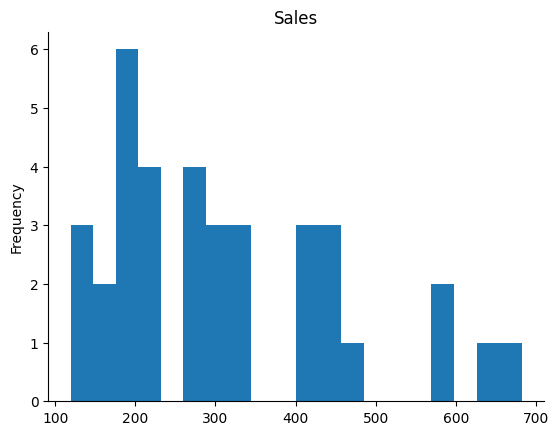

In [92]:
df['Sales'].plot(kind='hist', bins=20, title='Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

# **MinMax Scaling**

In [93]:
scaler = MinMaxScaler()
scaler.fit(df)
df['Scaled_Sales'] = scaler.transform(df)
df

,Sales,Scaled_Sales
Month,,
1-01,266.0,0.260707
1-02,145.9,0.047272
1-03,183.1,0.113382
1-04,119.3,0.000000
1-05,180.3,0.108406
1-06,168.5,0.087436
1-07,231.8,0.199929
1-08,224.5,0.186956
1-09,192.8,0.130620


# **Create the past sequence and its next output**

In [94]:
import numpy as np

# Convert DataFrame to numpy array
data = df['Scaled_Sales'].values

# Define sequence length
sequence_length = 4  # We will use the previous 4 data points to predict the next one

# Initialize lists to store input sequences (X) and output sequences (y)
X = []
y = []

# Create input-output pairs
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])  # Input sequence contains previous 4 data points
    y.append(data[i+sequence_length])   # Output is the next data point after the input sequence

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape input sequences to match LSTM input shape (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(X)


[[[0.2607073 ]
  [0.04727208]
  [0.11338191]
  [0.        ]]

 [[0.04727208]
  [0.11338191]
  [0.        ]
  [0.1084059 ]]

 [[0.11338191]
  [0.        ]
  [0.1084059 ]
  [0.08743558]]

 [[0.        ]
  [0.1084059 ]
  [0.08743558]
  [0.19992891]]

 [[0.1084059 ]
  [0.08743558]
  [0.19992891]
  [0.18695575]]

 [[0.08743558]
  [0.19992891]
  [0.18695575]
  [0.13062022]]

 [[0.19992891]
  [0.18695575]
  [0.13062022]
  [0.00639773]]

 [[0.18695575]
  [0.13062022]
  [0.00639773]
  [0.38599609]]

 [[0.13062022]
  [0.00639773]
  [0.38599609]
  [0.11835792]]

 [[0.00639773]
  [0.38599609]
  [0.11835792]
  [0.13328594]]

 [[0.38599609]
  [0.11835792]
  [0.13328594]
  [0.05366981]]

 [[0.11835792]
  [0.13328594]
  [0.05366981]
  [0.16136485]]

 [[0.13328594]
  [0.05366981]
  [0.16136485]
  [0.27368047]]

 [[0.05366981]
  [0.16136485]
  [0.27368047]
  [0.12813222]]

 [[0.16136485]
  [0.27368047]
  [0.12813222]
  [0.29802737]]

 [[0.27368047]
  [0.12813222]
  [0.29802737]
  [0.18962147]]

 [[0.128

In [95]:
import pandas as pd

# Convert numpy arrays to DataFrame
X_df = pd.DataFrame(X.reshape(X.shape[0], -1), columns=[f"X_{i+1}" for i in range(sequence_length)])
y_df = pd.DataFrame(y, columns=['Output'])

# Concatenate X and y DataFrames
result_df = pd.concat([X_df, y_df], axis=1)

# Display the DataFrame
result_df

,X_1,X_2,X_3,X_4,Output
0,0.260707,0.047272,0.113382,0.000000,0.108406
1,0.047272,0.113382,0.000000,0.108406,0.087436
2,0.113382,0.000000,0.108406,0.087436,0.199929
3,0.000000,0.108406,0.087436,0.199929,0.186956
4,0.108406,0.087436,0.199929,0.186956,0.130620
5,0.087436,0.199929,0.186956,0.130620,0.006398
6,0.199929,0.186956,0.130620,0.006398,0.385996
7,0.186956,0.130620,0.006398,0.385996,0.118358
8,0.130620,0.006398,0.385996,0.118358,0.133286
9,0.006398,0.385996,0.118358,0.133286,0.053670


# **Data Visualisation of Result_df**

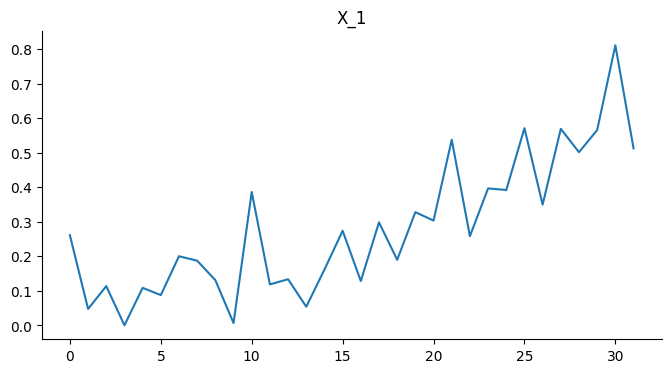

In [96]:
result_df['X_1'].plot(kind='line', figsize=(8, 4), title='X_1')
plt.gca().spines[['top', 'right']].set_visible(False)

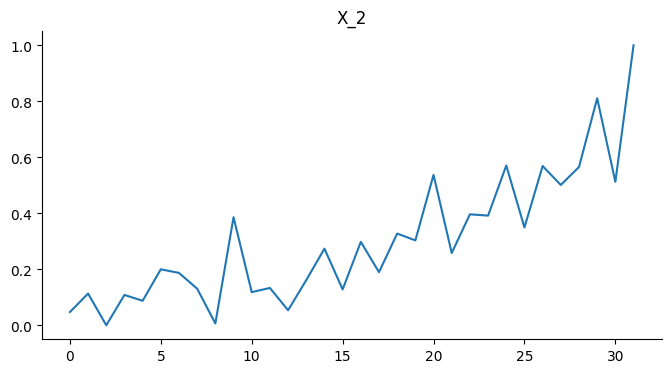

In [97]:
result_df['X_2'].plot(kind='line', figsize=(8, 4), title='X_2')
plt.gca().spines[['top', 'right']].set_visible(False)

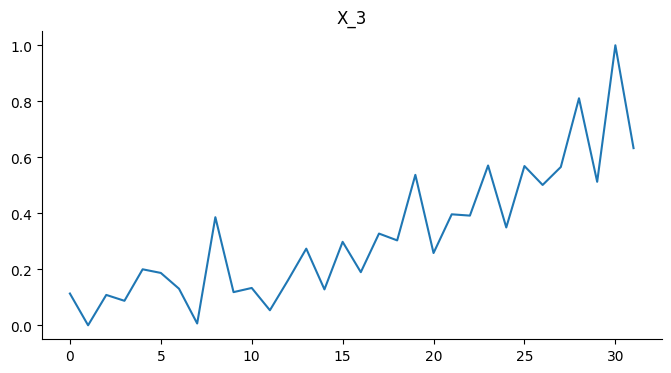

In [98]:
from matplotlib import pyplot as plt
result_df['X_3'].plot(kind='line', figsize=(8, 4), title='X_3')
plt.gca().spines[['top', 'right']].set_visible(False)

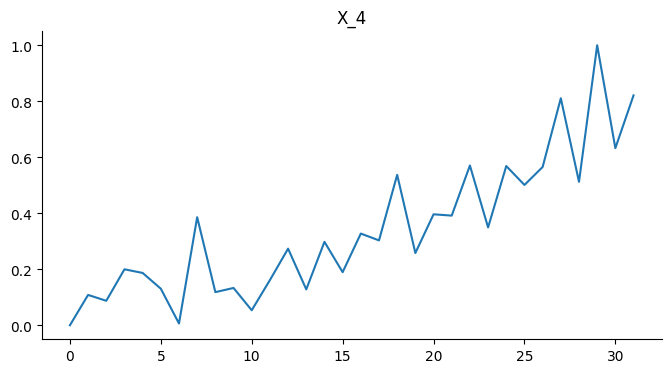

In [99]:
from matplotlib import pyplot as plt
result_df['X_4'].plot(kind='line', figsize=(8, 4), title='X_4')
plt.gca().spines[['top', 'right']].set_visible(False)

# **Train-Test Split**

In [100]:
# Split the data into train and test sets (70% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Further split the test set into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
print(X_test.shape)

(5, 4, 1)


### **Convert to Tensor**

In [101]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

### **LSTM**

In [125]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=512, output_size=1, p=0.1, num_layers=2):
        super().__init__()

        # Define the size of the hidden layer
        self.hidden_layer_size = hidden_layer_size

        # Define the LSTM layer with specified input size, hidden layer size, and dropout rate
        self.lstm = nn.LSTM(input_size, hidden_layer_size, dropout=p)

        # Define the linear layer for output
        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Initialize the hidden cell state
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # Pass the input sequence through the LSTM layer
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)

        # Pass the LSTM output through the linear layer for final prediction
        predictions = self.linear(lstm_out.view(len(input_seq), -1))

        # Return the last prediction in the sequence
        return predictions[-1]

In [103]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [104]:
train_loader=[]
val_loader= []
test_loader= []

for i in range(len(X_train)):
  train_loader.append((X_train[i], y_train[i]))
# print(train_loader)

for i in range(len(X_val)):
  val_loader.append((X_val[i], y_val[i]))

for i in range(len(X_test)):
  test_loader.append((X_test[i], y_test[i]))

print(test_loader)

[(tensor([[0.2580],
        [0.3963],
        [0.3917],
        [0.5706]]), tensor(0.3494)), (tensor([[0.3963],
        [0.3917],
        [0.5706],
        [0.3494]]), tensor(0.5687)), (tensor([[0.3917],
        [0.5706],
        [0.3494],
        [0.5687]]), tensor(0.5012)), (tensor([[0.5706],
        [0.3494],
        [0.5687],
        [0.5012]]), tensor(0.5653)), (tensor([[0.3494],
        [0.5687],
        [0.5012],
        [0.5653]]), tensor(0.8107))]


# **Train and Validate the Model**

In [126]:
def train_val(epochs, train_loader, val_loader, loss_function, optimizer, save_path="/content/"):
    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(1, epochs + 1):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        # Iterate over training data
        for seq, labels in train_loader:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                  torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calculate average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            # Iterate over validation data
            for seq_val, labels_val in val_loader:
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                      torch.zeros(1, 1, model.hidden_layer_size))

                y_pred_val = model(seq_val)
                loss_val = loss_function(y_pred_val, labels_val)
                val_loss += loss_val.item()

        # Calculate average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Print training and validation losses for each epoch
        if epoch % 25 == 1:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save the model checkpoint
        torch.save(model.state_dict(), f'{save_path}/model_epoch_{epoch}.pt')

    return train_losses, val_losses


In [106]:
epochs = 400
train_losses, val_losses = train_val(epochs, train_loader, val_loader, loss_function, optimizer)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/400], Train Loss: 0.0204, Val Loss: 0.1799
Epoch [26/400], Train Loss: 0.0116, Val Loss: 0.1226
Epoch [51/400], Train Loss: 0.0106, Val Loss: 0.0527
Epoch [76/400], Train Loss: 0.0101, Val Loss: 0.0421
Epoch [101/400], Train Loss: 0.0096, Val Loss: 0.0644
Epoch [126/400], Train Loss: 0.0087, Val Loss: 0.1109
Epoch [151/400], Train Loss: 0.0070, Val Loss: 0.1072
Epoch [176/400], Train Loss: 0.0070, Val Loss: 0.1631
Epoch [201/400], Train Loss: 0.0063, Val Loss: 0.1394
Epoch [226/400], Train Loss: 0.0060, Val Loss: 0.2592
Epoch [251/400], Train Loss: 0.0046, Val Loss: 0.2043
Epoch [276/400], Train Loss: 0.0066, Val Loss: 0.1714
Epoch [301/400], Train Loss: 0.0035, Val Loss: 0.1730
Epoch [326/400], Train Loss: 0.0008, Val Loss: 0.1192
Epoch [351/400], Train Loss: 0.0071, Val Loss: 0.0682
Epoch [376/400], Train Loss: 0.0037, Val Loss: 0.0760


# **Plot the Train and Validation Loss Vs Epochs**

In [107]:
def plot(epochs, train_losses, val_losses):
  # Plotting train and validation losses vs. epoch
  plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
  plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses vs. Epoch')
  plt.legend()
  plt.show()

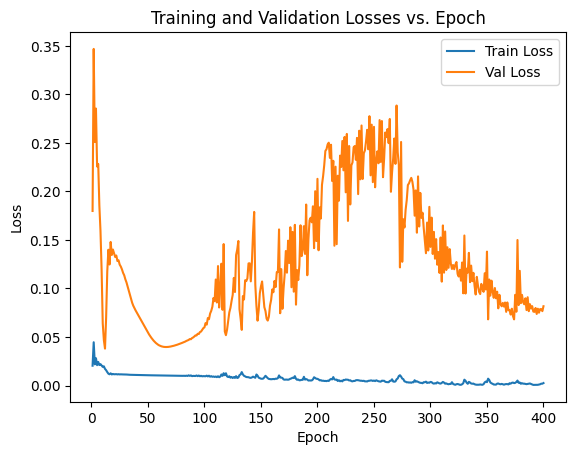

In [108]:
plot(epochs, train_losses, val_losses)

# **Evaluate the Model And Plot the Actual Vs Predicted wrt to month**

In [127]:
def evaluate(test_loader):
    # Set the model to evaluation mode
    model.eval()

    # Lists to store predicted and true values
    y_pred = []
    y_true = []

    # Evaluate the model on test data
    with torch.no_grad():
        for seq, labels in test_loader:
            # Get the model predictions
            test_outputs = model(seq)

            # Append the predicted values to the list
            y_pred.extend(test_outputs.numpy())

            # Append the true labels to the list
            y_true.append(labels.item())

    # Calculate the Mean Squared Error (MSE) between predicted and true values
    test_mse = mse(y_true, y_pred)
    print(f'Test MSE: {test_mse:.4f}')

    # Inverse transform the scaled predicted and true values
    y_true = scaler.inverse_transform(np.array(y_true).reshape(1, -1))
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(1, -1))

    # Plot the actual vs predicted sale prices
    plt.plot(month[22:27], y_true.T, label='Actual')
    plt.plot(month[22:27], y_pred.T, label='Predicted')
    plt.xlabel('Month')
    plt.ylabel('Sale Prices')
    plt.title('Actual Vs Predicted')
    plt.legend()
    plt.show()


Test MSE: 0.0821


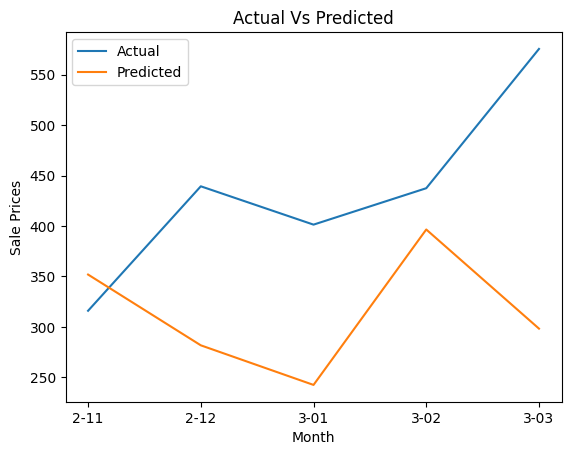

In [110]:
evaluate(test_loader)

# **Hyperparameter Tuning**

In [111]:
import itertools

epochs = 20

# Define ranges of hyperparameters
hidden_layer_sizes = [32, 64, 128]
dropout_values = [0.1, 0.2, 0.3]
num_layers_values = [1, 2, 3]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

best_loss = float('inf')
best_hyperparameters = {"hidden_layer_sizes": hidden_layer_sizes[0] , "dropout_values": dropout_values[0], "num_layers_values": num_layers_values[0], "learning_rate": learning_rate[0]}

# Iterate through all combinations of hyperparameters
for hidden_layer_size, dropout, num_layers, lr in itertools.product(hidden_layer_sizes, dropout_values, num_layers_values, learning_rate):

    # Create the LSTM model with current hyperparameters
    model = LSTM(hidden_layer_size=hidden_layer_size, p=dropout, num_layers=num_layers)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(1, epochs + 1):
      model.train()  # Set the model to training mode
      train_loss = 0.0

      for seq, labels in train_loader:
          optimizer.zero_grad()
          model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                              torch.zeros(1, 1, model.hidden_layer_size))

          y_pred = model(seq)
          loss = loss_function(y_pred, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()

      train_loss /= len(train_loader)

      # Validation loop
      model.eval()  # Set the model to evaluation mode
      val_loss = 0.0

      with torch.no_grad():
          for seq_val, labels_val in val_loader:
              model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                    torch.zeros(1, 1, model.hidden_layer_size))

              y_pred_val = model(seq_val)
              loss_val = loss_function(y_pred_val, labels_val)
              val_loss += loss_val.item()

      val_loss /= len(val_loader)

    if(val_loss < best_loss):
      best_hyperparameters["hidden_layer_sizes"] = hidden_layer_size
      best_hyperparameters["dropout_values"] = dropout
      best_hyperparameters["num_layers_values"] = num_layers
      best_hyperparameters["learning_rate"]=lr

      best_loss = val_loss

# Print the best hyperparameters and their corresponding validation loss
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Validation Loss:", best_loss)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/module

Best Hyperparameters:
{'hidden_layer_sizes': 32, 'dropout_values': 0.2, 'num_layers_values': 2, 'learning_rate': 0.1}
Best Validation Loss: 0.026398887537652627


### **Train the model using the best hyperparameters**

In [121]:
epochs = 250

model = LSTM(hidden_layer_size=best_hyperparameters["hidden_layer_sizes"], p=best_hyperparameters["dropout_values"], num_layers=best_hyperparameters["num_layers_values"])
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_hyperparameters["learning_rate"])

train_losses, val_losses = train_val(epochs, train_loader, val_loader, loss_function, optimizer)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/250], Train Loss: 0.0582, Val Loss: 0.2125
Epoch [26/250], Train Loss: 0.0310, Val Loss: 0.1631
Epoch [51/250], Train Loss: 0.0180, Val Loss: 0.1176
Epoch [76/250], Train Loss: 0.0179, Val Loss: 0.1287
Epoch [101/250], Train Loss: 0.0142, Val Loss: 0.1420
Epoch [126/250], Train Loss: 0.0137, Val Loss: 0.1589
Epoch [151/250], Train Loss: 0.0164, Val Loss: 0.1727
Epoch [176/250], Train Loss: 0.0130, Val Loss: 0.2057
Epoch [201/250], Train Loss: 0.0156, Val Loss: 0.1921
Epoch [226/250], Train Loss: 0.0124, Val Loss: 0.1666


### **Plot the model train and validation loss vs epochs**

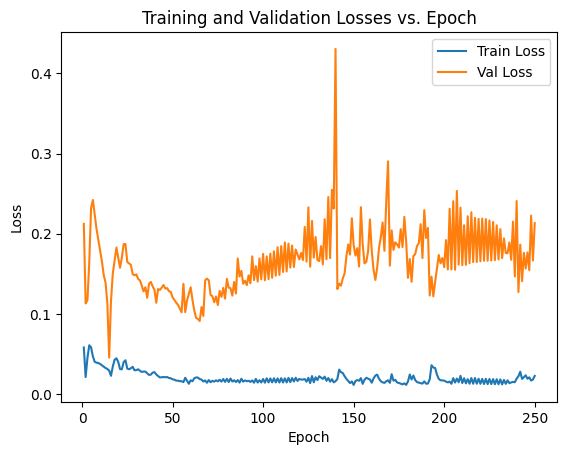

In [122]:
plot(epochs, train_losses, val_losses)

### **Evaluate the model**

Test MSE: 0.0508


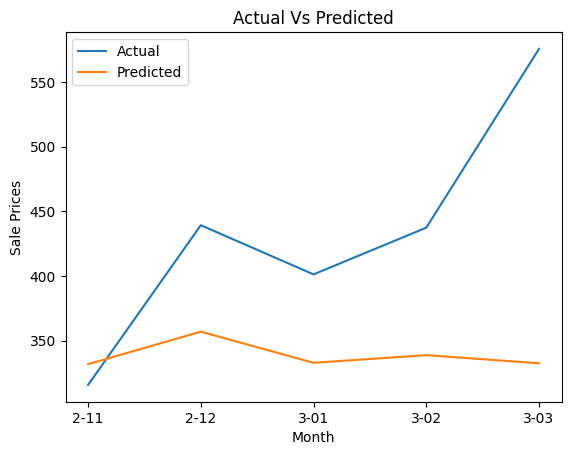

In [123]:
evaluate(test_loader)

# **Finetuning**

### **Choosing Best Optimizer**

In [114]:
optimizer1 = optim.Adam(model.parameters(), lr=0.001)
optimizer2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer3 = optim.Adagrad(model.parameters(), lr=0.001)
optimizer4 = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

# Store the optimizers in a list
optimizers_list = [optimizer1, optimizer2, optimizer3, optimizer4]
list_opt = {0: "Adam", 1: "SGD", 2: "Adagrad", 3: "RMSProp"}

opt = ""

t = 0
best_loss = float('inf')
epochs = 20

loss_list = []

for i in range(len(optimizers_list)):
  optimizer = optimizers_list[i]

  # Training loop
  for epoch in range(1, epochs + 1):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for seq_val, labels_val in val_loader:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                  torch.zeros(1, 1, model.hidden_layer_size))

            y_pred_val = model(seq_val)
            loss_val = loss_function(y_pred_val, labels_val)
            val_loss += loss_val.item()

    val_loss /= len(val_loader)

  loss_list.append(val_loss)
  if(val_loss < best_loss):
    opt = list_opt[i]
    t = i
    best_loss = val_loss

print("Best Optimizer :", opt, "val_loss:", loss_list[t])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Best Optimizer : RMSProp val_loss: 0.2553142920136452


### **Train using the best optimizer**

In [115]:
epochs = 250
optimizer = optimizer3

train_losses, val_losses = train_val(epochs, train_loader, val_loader, loss_function, optimizer)

Epoch [1/250], Train Loss: 0.0190, Val Loss: 0.2553
Epoch [26/250], Train Loss: 0.0190, Val Loss: 0.2545
Epoch [51/250], Train Loss: 0.0190, Val Loss: 0.2540
Epoch [76/250], Train Loss: 0.0190, Val Loss: 0.2535
Epoch [101/250], Train Loss: 0.0190, Val Loss: 0.2531
Epoch [126/250], Train Loss: 0.0190, Val Loss: 0.2527
Epoch [151/250], Train Loss: 0.0189, Val Loss: 0.2523
Epoch [176/250], Train Loss: 0.0189, Val Loss: 0.2520
Epoch [201/250], Train Loss: 0.0189, Val Loss: 0.2517
Epoch [226/250], Train Loss: 0.0189, Val Loss: 0.2513


### **Plotted the best optimizer curve of trin and validation loss vs epochs**

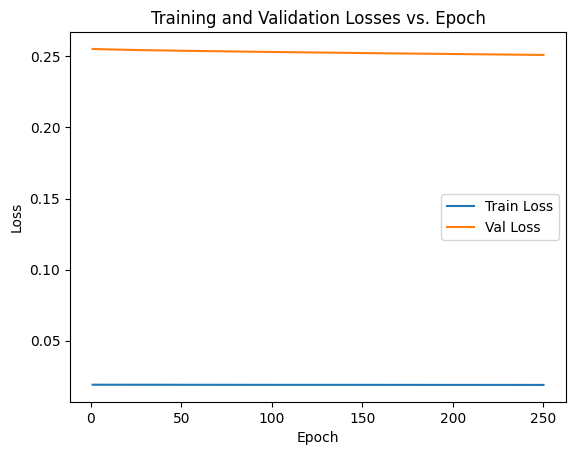

In [116]:
plot(epochs, train_losses, val_losses)

### **Evaluate the model**

Test MSE: 0.0742


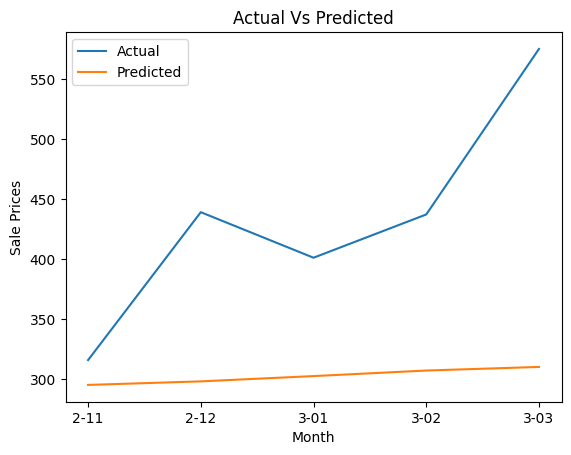

In [117]:
evaluate(test_loader)

# **Gradient Clipping**

### **Train and validate the model**

In [118]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

epochs = 250
# Training loop
for epoch in range(1, epochs + 1):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters() , 0.1 ) # using gradient clipping

        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for seq_val, labels_val in val_loader:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                  torch.zeros(1, 1, model.hidden_layer_size))

            y_pred_val = model(seq_val)
            loss_val = loss_function(y_pred_val, labels_val)
            val_loss += loss_val.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 25 == 1:
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/250], Train Loss: 0.0257, Val Loss: 0.2717
Epoch [26/250], Train Loss: 0.0128, Val Loss: 0.0621
Epoch [51/250], Train Loss: 0.0108, Val Loss: 0.3004
Epoch [76/250], Train Loss: 0.0108, Val Loss: 0.2020
Epoch [101/250], Train Loss: 0.0113, Val Loss: 0.3899
Epoch [126/250], Train Loss: 0.0137, Val Loss: 0.1445
Epoch [151/250], Train Loss: 0.0101, Val Loss: 0.2182
Epoch [176/250], Train Loss: 0.0107, Val Loss: 0.0700
Epoch [201/250], Train Loss: 0.0088, Val Loss: 0.1333
Epoch [226/250], Train Loss: 0.0073, Val Loss: 0.1417


### **Plot the model train and validation loss vs epochs**

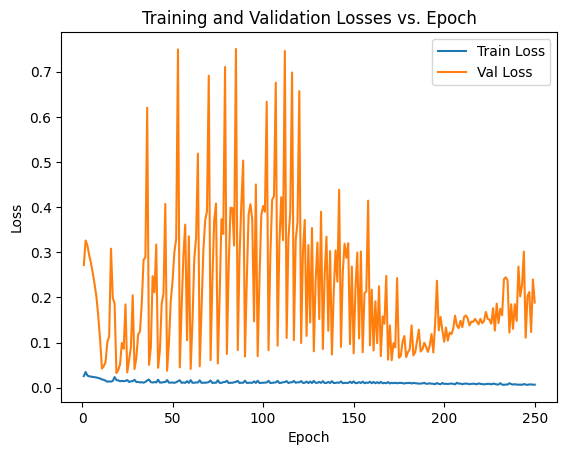

In [119]:
plot(epochs, train_losses, val_losses)

### **Evaluate the model**

Test MSE: 0.2731


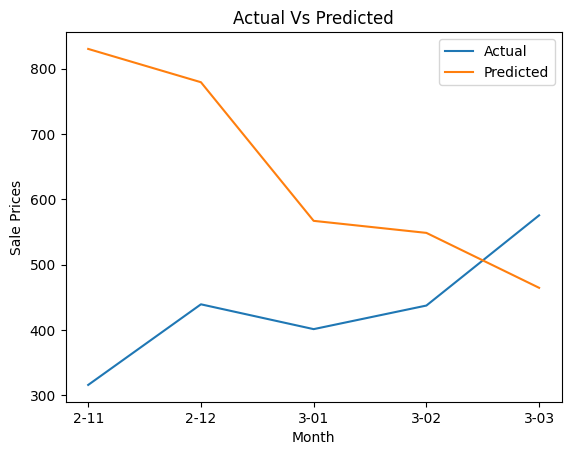

In [120]:
evaluate(test_loader)